In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np
import pandas as pd
from collections import Counter
import os
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import random
import copy
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from skimage.io import imread
import sys
from tqdm import tqdm
import torchvision.transforms.functional as TF


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


filename = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for fn in filenames:
        #print(os.path.join(dirname, filename))
        filename.append(fn)
fn_count = len(filename)
print(fn_count)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


7363


In [4]:
'''
save_dir = 'output'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
'''


"\nsave_dir = 'output'\nif not os.path.exists(save_dir):\n    os.makedirs(save_dir)\n"

In [5]:
def count_files(directory_path):
   
    counter = 0
    dir_files = os.listdir(directory_path)

 
    for name in dir_files :

        full_path = os.path.join(directory_path, name)

        if os.path.isfile(full_path):
            counter += 1

    return counter

TRAIN_PATH_A  = '/kaggle/input/gan-getting-started/monet_jpg/' #'data/train/train_monet'
TRAIN_PATH_B  = '/kaggle/input/gan-getting-started/photo_jpg/' #'data/train/train_photo'

print('Monet directory:', count_files(TRAIN_PATH_A))
print('Photo directory:', count_files(TRAIN_PATH_B))

Monet directory: 300
Photo directory: 7038


In [6]:
train_files_A = next(os.walk(TRAIN_PATH_A))[2]
train_files_B = next(os.walk(TRAIN_PATH_B))[2]

#test_files_A = next(os.walk(TEST_PATH_A))[2]
#test_files_B = next(os.walk(TEST_PATH_B))[2]
print(len(train_files_A))

300


In [7]:
#Checking training data shape
demo = imread(TRAIN_PATH_A + train_files_A[0])
print(demo.shape)

(256, 256, 3)


In [8]:
X_train_A = np.zeros((len(train_files_A), 256, 256, 3), dtype = np.uint8)
X_train_B = np.zeros((len(train_files_B), 256, 256, 3), dtype = np.uint8)

#X_test_A = np.zeros((len(test_files_A), 256, 256, 3), dtype = np.uint8)
#X_test_B = np.zeros((len(test_files_B), 256, 256, 3), dtype = np.uint8)

print('Getting training images from set A...')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_files_A), total = len(train_files_A)):
  img_path = TRAIN_PATH_A + id_
  img = imread(img_path)[:, :, :3]
  X_train_A[n] = img

print('Getting training images from set B...')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_files_B), total = len(train_files_B)):
  img_path = TRAIN_PATH_B + id_
  img = imread(img_path)[:, :, :3]
  X_train_B[n] = img

print('Getting testing images from set A...')
sys.stdout.flush()
'''
for n, id_ in tqdm(enumerate(test_files_A), total = len(test_files_A)):
  img_path = TEST_PATH_A + id_
  img = imread(img_path)[:, :, :3]
  X_test_A[n] = img

print('Getting testing images from set B...')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_files_B), total = len(test_files_B)):
  img_path = TEST_PATH_B + id_
  img = imread(img_path)[:, :, :3]
  X_test_B[n] = img
'''
print('Done!')
plt.show()

Getting training images from set A...


100%|██████████| 300/300 [00:02<00:00, 127.77it/s]

Getting training images from set B...



100%|██████████| 7038/7038 [00:47<00:00, 148.84it/s]

Getting testing images from set A...
Done!


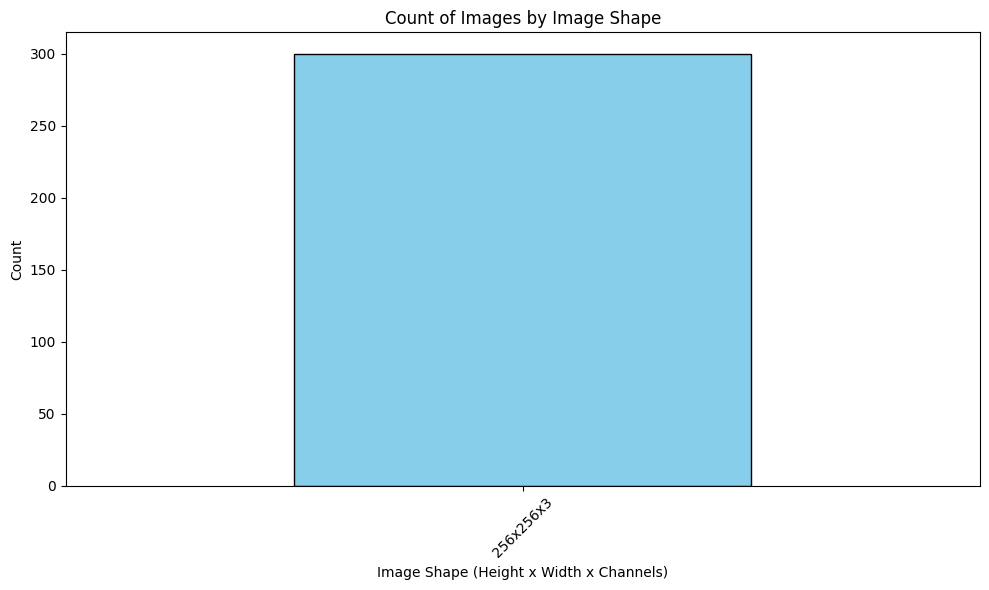

In [9]:
def img_shape(directory_path):
    shapes = []
    for foldername, _, filenames in os.walk(directory_path):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            
            img = cv2.imread(file_path)
            if img is not None:
                shapes.append(img.shape)

    return shapes

shapes = img_shape(TRAIN_PATH_A)
df_monet = pd.DataFrame(shapes, columns=['Height', 'Width', 'Channels']) 
df_monet['Shape'] = df_monet[['Height', 'Width', 'Channels']].astype(str).agg('x'.join, axis=1)
plt.figure(figsize=(10,6))
df_monet['Shape'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Count of Images by Image Shape')
plt.xlabel('Image Shape (Height x Width x Channels)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

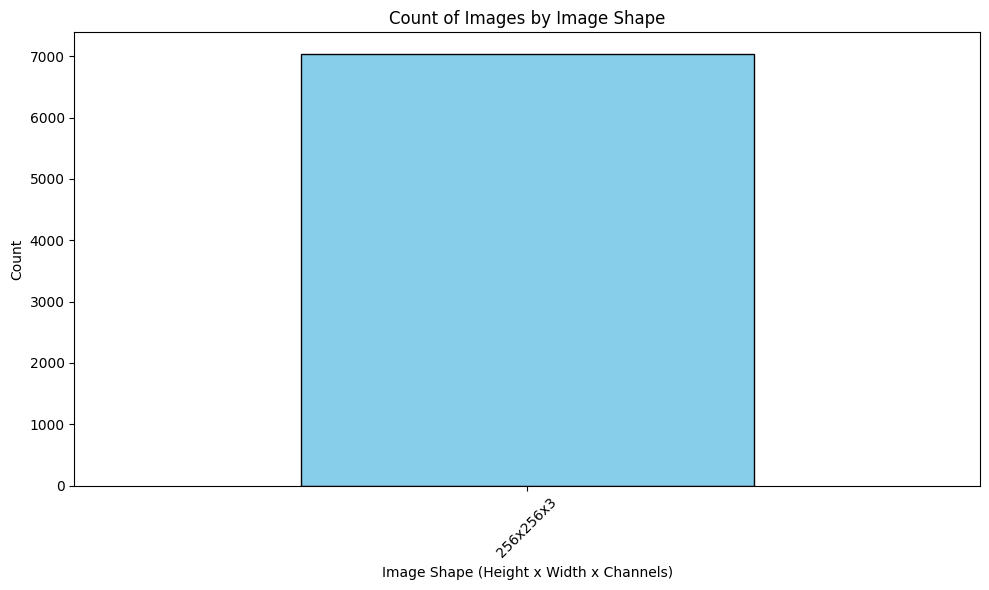

In [10]:
shapes = img_shape(TRAIN_PATH_B)
df_photo = pd.DataFrame(shapes, columns=['Height', 'Width', 'Channels'])
df_photo['Shape'] = df_photo[['Height', 'Width', 'Channels']].astype(str).agg('x'.join, axis=1)
plt.figure(figsize=(10,6))
df_photo['Shape'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Count of Images by Image Shape')
plt.xlabel('Image Shape (Height x Width x Channels)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

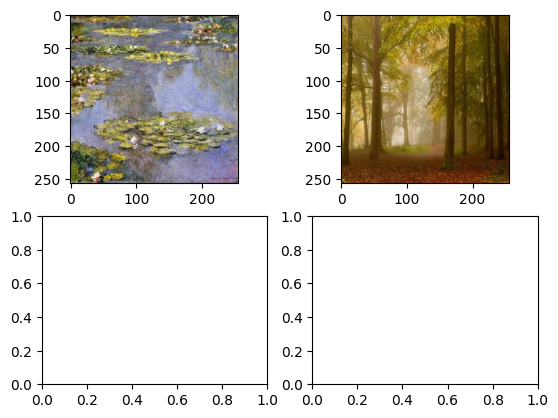

In [11]:
#Show 1 images per folder 
fig, axis = plt.subplots(2,2)
axis[0][0].imshow(X_train_A[0].astype(np.uint8))
axis[0][1].imshow(X_train_B[0].astype(np.uint8))

In [12]:
#Random Jitter Using Data Augmentation

class pix2pix(Dataset):
    def __init__(self, input_imgs_np):
        self.input_imgs_np = input_imgs_np
        
    def transform(self, input_img_np):
        input_img = TF.to_pil_image(input_img_np)
        input_img = TF.resize(input_img, (286, 286))
        
        random_crop = transforms.RandomCrop((256, 256))
        input_img = random_crop(input_img)
        
        if random.random() > 0.5:
            input_img = TF.hflip(input_img)
            
        input_tensor = TF.to_tensor(input_img)
        return input_tensor
    
    def __len__(self):
        return len(self.input_imgs_np)
    
    def __getitem__(self, idx):
        input_img_np = self.input_imgs_np[idx]
        input_tensor = self.transform(input_img_np)
        return input_tensor  

In [13]:
train_dataset_A = pix2pix(X_train_A)
train_loader_A = DataLoader(train_dataset_A, batch_size = 1, shuffle = True)

train_dataset_B = pix2pix(X_train_B)
train_loader_B = DataLoader(train_dataset_B, batch_size = 1, shuffle = True)

In [14]:
#Passing Data to list
train_A = []
train_B = []

for img in train_loader_A:
  train_A.append(img)

for img in train_loader_B:
  train_B.append(img)

In [15]:
print(len(train_A))
print(train_A[0].shape)

300
torch.Size([1, 3, 256, 256])


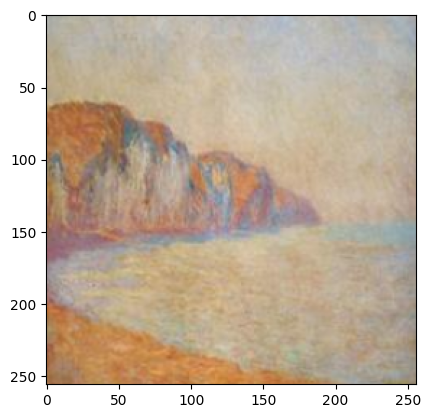

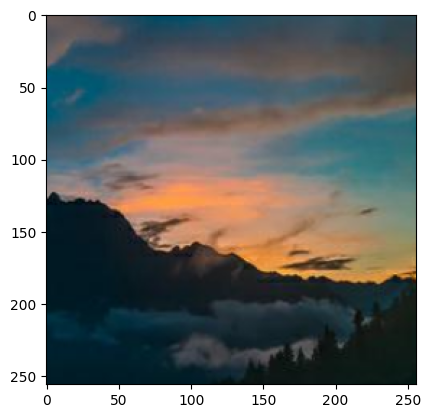

In [16]:
x_np = np.array(TF.to_pil_image(train_A[0][0]))
plt.imshow(x_np)
plt.show()

x_np = np.array(TF.to_pil_image(train_B[0][0]))
plt.imshow(x_np)
plt.show()


In [3]:
#Weight Initialization from Normal distribution
def weight_init(instance):
    classname = instance.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(instance.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(instance.weight.data, 0.0, 0.02)
        nn.init.constant_(instance.bias.data, 0.0)

In [5]:
#Convolutional & Fractional Convolution Blocks With ReLU Activation
def conv_block(in_channels, out_channels, *args, **kwargs):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, *args, **kwargs),
      nn.InstanceNorm2d(out_channels),
      nn.ReLU()
  )

def deconv_block(in_channels, out_channels, *args, **kwargs):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, *args, **kwargs),
      nn.InstanceNorm2d(out_channels),
      nn.ReLU()
  )  

In [19]:
#Resnet Module

class resnet(nn.Module):
  def __init__(self, in_channels, n_filters):
    super().__init__()
    self.conv_block_1 = conv_block(in_channels, n_filters, kernel_size = (3, 3), padding = 1, padding_mode = 'reflect')
    self.conv_2 = nn.Conv2d(n_filters, n_filters, kernel_size = (3, 3), padding = 1, padding_mode = 'reflect')
    self.conv_2_in = nn.InstanceNorm2d(n_filters)

  def forward(self, x):
    c = self.conv_block_1(x)
    c = self.conv_2(c)
    c = self.conv_2_in(c)
    out = torch.cat((c, x), axis = 1)
    return out

In [20]:
#Generator 
class generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_blocks = nn.Sequential(
        conv_block(3, 64, kernel_size = (7, 7), padding = 3, padding_mode = 'reflect'),
        conv_block(64, 128, kernel_size = (3, 3), stride = 2, padding = 1, padding_mode = 'reflect'),
        conv_block(128, 256, kernel_size = (3, 3), stride = 2, padding = 1, padding_mode = 'reflect'),
    )

    self.resnet_blocks = nn.Sequential(
        resnet(256, 256),
        resnet(512, 256),
        resnet(768, 256),
        resnet(1024, 256),
        resnet(1280, 256),
        resnet(1536, 256),
        resnet(1792, 256),
        resnet(2048, 256),
        resnet(2304, 256)
      )
    
    self.deconv_blocks = nn.Sequential(
        deconv_block(2560, 128, kernel_size = (3, 3), stride = 2, padding = 1, output_padding = 1),
        deconv_block(128, 64, kernel_size = (3, 3), stride = 2, padding = 1, output_padding = 1),
        nn.Conv2d(64, 3, kernel_size = (7, 7), padding = 3, padding_mode = 'reflect'),
        nn.InstanceNorm2d(3),
        nn.Tanh()
    )

  def forward(self, x):
    x = self.conv_blocks(x)

    x = self.resnet_blocks(x)

    out = self.deconv_blocks(x)

    return out
     

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
#initialize the generator
#Creating generator objects
gen_AtoB = generator()
gen_AtoB = gen_AtoB.float()
gen_AtoB = gen_AtoB.to(device)
gen_AtoB.apply(weight_init)

gen_BtoA = generator()
gen_BtoA = gen_BtoA.float()
gen_BtoA = gen_BtoA.to(device)
gen_BtoA.apply(weight_init)

#Printing one instance
print(gen_AtoB)

#Total trainable params
total_params = sum(p.numel() for p in gen_AtoB.parameters() if p.requires_grad)
print(total_params)

In [ ]:
#Convolutional Block with Leaky RELU
def conv_block_leaky(in_channels, out_channels, *args, **kwargs):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, *args, **kwargs),
      nn.InstanceNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [ ]:
#Discriminator Model
class discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = (4, 4), stride = 2, padding = 1),
        nn.LeakyReLU(negative_slope = 0.2)
    )

    self.conv_blocks = nn.Sequential(
        conv_block_leaky(64, 128, kernel_size = (4, 4), stride = 2, padding = 1),
        conv_block_leaky(128, 256, kernel_size = (4, 4), stride = 2, padding = 1),
        nn.ZeroPad2d(1),
        conv_block_leaky(256, 512, kernel_size = (4, 4), stride = 1)
    )

    self.conv_block_last = nn.Sequential(
        nn.ZeroPad2d(1),
        nn.Conv2d(512, 1, kernel_size = (4, 4), stride = 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    
    x = self.conv_blocks(x)

    out = self.conv_block_last(x) 

    return out

In [ ]:
#Creating discriminator objects
disc_A = discriminator()
disc_A = disc_A.float()
disc_A = disc_A.to(device)
disc_A.apply(weight_init)

disc_B = discriminator()
disc_B = disc_B.float()
disc_B = disc_B.to(device)
disc_B.apply(weight_init)

#Printing one instance
print(disc_A)

#Total trainable params
total_params = sum(p.numel() for p in disc_A.parameters() if p.requires_grad)
print(total_params)

In [ ]:
#Adversarial Losses
def gen_loss_gan(gen_disc_out):
  target = torch.ones((gen_disc_out.shape[0], 1, 30, 30)).to(device)
  loss = nn.MSELoss()(gen_disc_out.float(), target.float())
  return loss

def disc_loss_gan(real_out, fake_out):
  real_target = torch.ones((real_out.shape[0], 1, 30, 30)).to(device)
  fake_target = torch.zeros((fake_out.shape[0], 1, 30, 30)).to(device)
  real_loss = nn.MSELoss()(real_out.float(), real_target.float())
  fake_loss = nn.MSELoss()(fake_out.float(), fake_target.float())
  total_loss = (real_loss + fake_loss)/2.0
  return total_loss

In [ ]:
#Adversarial Losses
def gen_loss_gan(gen_disc_out):
  target = torch.ones((gen_disc_out.shape[0], 1, 30, 30)).to(device)
  loss = nn.MSELoss()(gen_disc_out.float(), target.float())
  return loss

def disc_loss_gan(real_out, fake_out):
  real_target = torch.ones((real_out.shape[0], 1, 30, 30)).to(device)
  fake_target = torch.zeros((fake_out.shape[0], 1, 30, 30)).to(device)
  real_loss = nn.MSELoss()(real_out.float(), real_target.float())
  fake_loss = nn.MSELoss()(fake_out.float(), fake_target.float())
  total_loss = (real_loss + fake_loss)/2.0
  return total_loss

In [ ]:
#Training Data Generator

def generate_real_sample(dataset):
  idx = random.randint(0, len(dataset) - 1)
  return dataset[idx]

def generate_fake_sample(gen_obj, img_obj):
  img_obj = img_obj.to(device)
  fake_img = gen_obj(img_obj.float())
  return fake_img

In [ ]:
out_sample = generate_fake_sample(gen_AtoB, train_A[0])
print(isinstance(train_A[0], torch.Tensor))
print(isinstance(out_sample, torch.Tensor))

In [ ]:
#Image Pool
def update_pool(pool, image):
  
  if len(pool) < 50:
    pool.append(image)
    return image

  else:
    if random.random() > 0.5:
      p = random.randint(0, len(pool) - 1)
      tmp = pool[p]
      pool[p] = image
      return tmp

    else:
      return image

In [ ]:
#Defining Optimizer
gen_opt_AtoB = optim.Adam(gen_AtoB.parameters(), lr = 0.0002, betas = (0.5, 0.999))
gen_opt_BtoA = optim.Adam(gen_BtoA.parameters(), lr = 0.0002, betas = (0.5, 0.999))

disc_opt_A = optim.Adam(disc_A.parameters(), lr = 0.0002, betas = (0.5, 0.999))
disc_opt_B = optim.Adam(disc_B.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [ ]:

def train(gen_AtoB, gen_BtoA, disc_A, disc_B, gen_opt_AtoB, gen_opt_BtoA, disc_opt_A, disc_opt_B, train_A, train_B, num_epochs, Lambda):

  gen_AtoB_losses = []
  gen_BtoA_losses = []
  disc_A_losses = []
  disc_B_losses = []

  gen_AtoB.train()
  gen_BtoA.train()
  disc_A.train()
  disc_B.train()

  sample_img_A = train_A[0].to(device)
  sample_img_B = train_B[0].to(device)

  for epoch in range(num_epochs + 1):
    
    gen_AtoB_total = 0
    gen_BtoA_total = 0
    disc_A_total = 0
    disc_B_total = 0

    pool_A = []
    pool_B = []
    
    for _ in range(len(train_A)):

      real_A = generate_real_sample(train_A)
      real_A = real_A.to(device)
      real_B = generate_real_sample(train_B)
      real_B = real_B.to(device)

      fake_A = generate_fake_sample(gen_BtoA, real_B)
      fake_B = generate_fake_sample(gen_AtoB, real_A)
      
      #Discriminator A training
      disc_opt_A.zero_grad()
      
      real_disc_A_out = disc_A(real_A.float())
      fake_disc_A_in = fake_A.detach()
      fake_disc_A_in = update_pool(pool_A, fake_disc_A_in)
      
      fake_disc_A_out = disc_A(fake_disc_A_in.float())
      disc_loss_A = disc_loss_gan(real_disc_A_out, fake_disc_A_out)
      disc_A_total += disc_loss_A 

      disc_loss_A.backward()
      disc_opt_A.step()

      #Discriminator B training
      disc_opt_B.zero_grad()
      
      real_disc_B_out = disc_B(real_B.float())
      fake_disc_B_in = fake_B.detach()
      fake_disc_B_in = update_pool(pool_B, fake_disc_B_in)
      
      fake_disc_B_out = disc_A(fake_disc_B_in.float())
      disc_loss_B = disc_loss_gan(real_disc_B_out, fake_disc_B_out)
      disc_B_total += disc_loss_B 

      disc_loss_B.backward()
      disc_opt_B.step()

      #Generator AtoB training
      gen_opt_AtoB.zero_grad()

      real_fake_out_B = disc_B(fake_B.float())                 #Calculating adversarial loss
      gen_AtoB_gan_loss = gen_loss_gan(real_fake_out_B)

      fake_A_detach = fake_A.detach()                          #Calculating cyclic consistency loss
      recon_B = generate_fake_sample(gen_AtoB, fake_A_detach)
      gen_AtoB_cyc_loss = cycle_loss(real_B, recon_B)

      gen_AtoB_loss = gen_AtoB_gan_loss + Lambda*gen_AtoB_cyc_loss
      gen_AtoB_total += gen_AtoB_loss

      gen_AtoB_loss.backward()
      gen_opt_AtoB.step()

      #Generator BtoA training
      gen_opt_BtoA.zero_grad()

      real_fake_out_A = disc_A(fake_A.float())                  #Calculating adversarial loss
      gen_BtoA_gan_loss = gen_loss_gan(real_fake_out_A)

      fake_B_detach = fake_B.detach()                           #Calculating cyclic consistency loss
      recon_A = generate_fake_sample(gen_BtoA, fake_B_detach)
      gen_BtoA_cyc_loss = cycle_loss(real_A, recon_A)

      gen_BtoA_loss = gen_BtoA_gan_loss + Lambda*gen_BtoA_cyc_loss
      gen_BtoA_total += gen_BtoA_loss

      gen_BtoA_loss.backward()
      gen_opt_BtoA.step()

    gen_AtoB_losses.append(gen_AtoB_total)
    gen_BtoA_losses.append(gen_BtoA_total)
    disc_A_losses.append(disc_A_total)
    disc_B_losses.append(disc_B_total)

    print('Epoch ', epoch, ' - ', 'Gen_A2B_Loss = ', gen_AtoB_total/len(train_A), ' Gen_B2A_Loss = ', gen_BtoA_total/len(train_A))
    sys.stdout.flush()
    print('Disc_A_Loss = ', disc_A_total/len(train_A), ' Disc_B_Loss = ', disc_B_total/len(train_A))
    sys.stdout.flush()

    #Printing a set of images to monitor progress every 5 epochs
    ''' 
    if epoch % 5 == 0:
      gen_AtoB.eval()
      sample_out_B = gen_AtoB(sample_img_A.float())
      gen_AtoB.train()

      gen_BtoA.eval()
      sample_out_A = gen_BtoA(sample_img_B.float())
      gen_BtoA.train()

      sample_img_A = sample_img_A.cpu()
      sample_img_B = sample_img_B.cpu()
      sample_out_A = sample_out_A.cpu()
      sample_out_B = sample_out_B.cpu()

      sample_img_A_np = np.array(TF.to_pil_image(sample_img_A[0]))
      sample_img_B_np = np.array(TF.to_pil_image(sample_img_B[0]))
      sample_out_A_np = np.array(TF.to_pil_image(sample_out_A[0]))
      sample_out_B_np = np.array(TF.to_pil_image(sample_out_B[0]))

      fig, axis = plt.subplots(2, 2)
      axis[0][0].imshow(sample_img_A_np.astype(np.uint8))
      axis[0][0].axis('off')
      axis[1][0].imshow(sample_out_B_np.astype(np.uint8))
      axis[1][0].axis('off')
      axis[0][1].imshow(sample_img_B_np.astype(np.uint8))
      axis[0][1].axis('off')
      axis[1][1].imshow(sample_out_A_np.astype(np.uint8))
      axis[1][1].axis('off')
      plt.show()
      '''


In [7]:
#Start the training process
# Define the number of epochs and Lambda
num_epochs = 100  # Or the number of epochs you want to train for
Lambda = 10 
train(gen_AtoB, gen_BtoA, disc_A, disc_B, gen_opt_AtoB, gen_opt_BtoA, disc_opt_A, disc_opt_B, train_A, train_B, num_epochs, Lambda)

NameError: name 'train' is not defined

In [8]:
# Ensure your model is saved during or after training
torch.save(gen_AtoB.state_dict(), './models/gen_AtoB_model.pth')
# Create directory to save the generated images if not exists
models = 'models'
os.makedirs(models, exist_ok=True)

NameError: name 'torch' is not defined

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from PIL import Image
from torchvision.transforms import ToTensor
import os

# Load the trained gen_AtoB model
gen_AtoB = generator() # Initialize your model architecture
gen_AtoB = gen_AtoB.to(device)
gen_AtoB.load_state_dict(torch.load('./models/gen_AtoB_model.pth'))
gen_AtoB.eval()  # Set the model to evaluation mode

# Assuming monet_loader is a DataLoader that loads your Monet paintings filenames
monet_loader = DataLoader(train_files_B, batch_size=1)  # Create a DataLoader for your Monet dataset filenames

# Create directory to save the generated images if not exists
output_dir = 'working/images'
os.makedirs(output_dir, exist_ok=True)

# Create a transformation pipeline to convert the loaded PIL image to tensor
transform = ToTensor()

# Generate and save images
for i, monet_image_filename in enumerate(monet_loader):
    if i >= 7030:  # Stop after generating 7000 images
        break
    
    # Load the image from the filename
    image_path = os.path.join(TRAIN_PATH_B, monet_image_filename[0])  # You'll need to provide the correct path where the images are stored
    pil_image = Image.open(image_path)
    tensor_image = transform(pil_image).unsqueeze(0).to(device)  # Convert the image to tensor and add batch dimension

    with torch.no_grad():
        generated_photo = gen_AtoB(tensor_image)
    
    save_image(generated_photo, os.path.join(output_dir, f'generated_photo_{i}.png'))

print(f'Generated {i+1} photos and saved to {output_dir}')

